# Importando coisas

In [4]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Declarando variáveis

In [5]:
T = 35      # Tempo de buffering Alvo
N2 = 0.25   # Reduzir
N1 = 0.5    # Reduzir pouco
Z = 1       # Não alterar
P1 = 1.5    # Aumentar pouco
P2 = 2      # Aumentar

# Declarando antecedentes e consequentes (universos)

In [6]:
bTime = ctrl.Antecedent(np.arange(0, 4*T+1, 1), 'Buffering time t (s)')
print(np.arange(0, 4*T+1, 1))
bTimeDiff = ctrl.Antecedent(np.arange(-T, 4*T+1, 1), 'Differential of the buffering time Δt (s)')
print(np.arange(-T, 4*T+1, 1))
qualityDiff = ctrl.Consequent(np.arange(0, P2 + 0.05, 0.05), 'increase/reduce bitrate factor for next segment')
print(np.arange(0, 2.05, 0.05))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140]
[-35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18
 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0
   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  

# Montando membership functions + vendo resultados

C:\Users\theca\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\theca\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\theca\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


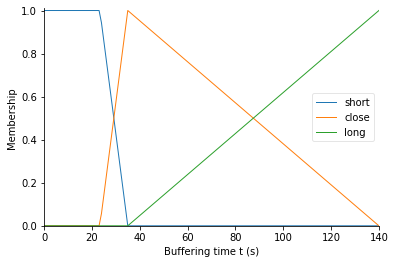

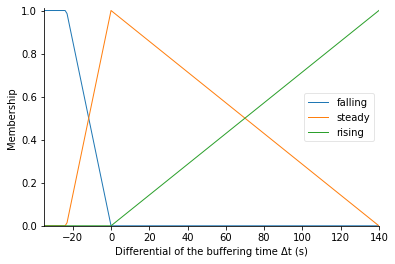

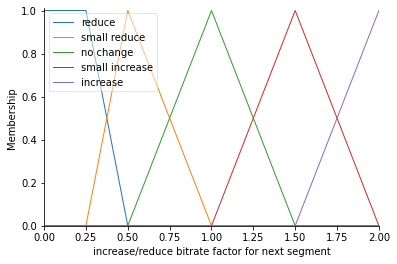

In [11]:
# Diferença entre tempo de buffering atual com um valor alvo T = 35s
bTime['short'] = fuzz.trapmf(bTime.universe, [0, 0, (2*T/3), T])
bTime['close'] = fuzz.trimf(bTime.universe, [(2*T/3), T, 4*T])
bTime['long'] = fuzz.trimf(bTime.universe, [T, 4*T, 4*T])

# Comportamento da taxa de transferência entre tempos de buffering consecutivos
bTimeDiff['falling'] = fuzz.trapmf(bTimeDiff.universe, [-T, -T, (-2*T/3), 0])
bTimeDiff['steady'] = fuzz.trimf(bTimeDiff.universe, [(-2*T/3), 1, 4*T])
bTimeDiff['rising'] = fuzz.trimf(bTimeDiff.universe, [0, 4*T, 4*T])

# Fator de incremento/decremento da qualidade do próximo segmento
qualityDiff['reduce'] = fuzz.trapmf(qualityDiff.universe, [0, 0, N2, N1])
qualityDiff['small reduce'] = fuzz.trimf(qualityDiff.universe, [N2, N1, Z])
qualityDiff['no change'] = fuzz.trimf(qualityDiff.universe, [N1, Z, P1])
qualityDiff['small increase'] = fuzz.trimf(qualityDiff.universe, [Z, P1, P2])
qualityDiff['increase'] = fuzz.trimf(qualityDiff.universe, [P1, P2, P2])

bTime.view()
bTimeDiff.view()
qualityDiff.view()

# Montando regras

In [8]:
rule1 = ctrl.Rule(bTime['short'] & bTimeDiff['falling'], qualityDiff['reduce'])
rule2 = ctrl.Rule(bTime['close'] & bTimeDiff['falling'], qualityDiff['small reduce'])
rule3 = ctrl.Rule(bTime['long'] & bTimeDiff['falling'], qualityDiff['no change'])

rule4 = ctrl.Rule(bTime['short'] & bTimeDiff['steady'], qualityDiff['small reduce'])
rule5 = ctrl.Rule(bTime['close'] & bTimeDiff['steady'], qualityDiff['no change'])
rule6 = ctrl.Rule(bTime['long'] & bTimeDiff['steady'], qualityDiff['small increase'])

rule7 = ctrl.Rule(bTime['short'] & bTimeDiff['rising'], qualityDiff['no change'])
rule8 = ctrl.Rule(bTime['close'] & bTimeDiff['rising'], qualityDiff['small increase'])
rule9 = ctrl.Rule(bTime['long'] & bTimeDiff['rising'], qualityDiff['increase'])

# Falling
# rule1.view()
# rule2.view()
# rule3.view()

# Steady
# rule4.view()
# rule5.view()
# rule6.view()

# Rising
# rule7.view()
# rule8.view()
# rule9.view()


## Declarando/Configurando o sistema de controle

In [9]:
FDASHControl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
FDASH = ctrl.ControlSystemSimulation(FDASHControl)

## Calculando saída/mostrando exemplo

Output: fator de acréscimo/decréscimo = 0.5701746846895647


C:\Users\theca\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


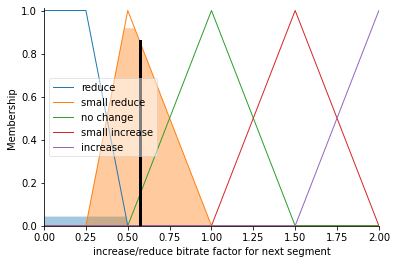

In [10]:
FDASH.input['Buffering time t (s)'] = 2
FDASH.input['Differential of the buffering time Δt (s)'] = -1

FDASH.compute()

output = FDASH.output['increase/reduce bitrate factor for next segment']
print("Output: fator de acréscimo/decréscimo =", output)
qualityDiff.view(sim=FDASH)